In [9]:
from datalib import BinanceTradeLoader 
import math
import numpy as np
import pandas as pd
import seaborn as sns
from calendar import monthrange
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import asyncio
import tensorflow as tf

In [10]:
resample_interval = 1000 #milliseconds
local_cache_path = "/media/corvin/BigData/Crypto/binance/"
trade_loader = BinanceTradeLoader(local_cache_path)

In [11]:
def make_monthly_volume_vwap_and_imbalance(symbol, month, year, resample_interval) :
    num_days = monthrange(year, month)[1]
    return pd.concat(make_daily_volume_vwap_and_imbalance(symbol, day, month, year, resample_interval) for day in range(1,num_days + 1)).reset_index(drop = True)

def make_daily_volume_vwap_and_imbalance(symbol, day, month, year, resample_interval) :
    trades = trade_loader.load_daily_trades_usdt_margined(symbol, day, month, year)
    resampled = make_volume_vwap_and_imbalance(trades, resample_interval)
    del trades
    return resampled
def make_volume_vwap_and_imbalance(trades, resample_interval = 1000) :
    trades["buy_usdt_volume"] = trades["price"] * trades["qty"] *(1 - trades["isBuyerMaker"])
    trades["sell_usdt_volume"] = trades["price"] * trades["qty"] *trades["isBuyerMaker"]
    trades["usdt_volume"] = trades["price"] * trades["qty"]
    resampled =  trades.resample(f'{resample_interval}ms', on = "time").agg({"buy_usdt_volume" : np.sum, "sell_usdt_volume" : np.sum, "usdt_volume" : np.sum, "qty" : np.sum}).reset_index()
    resampled["buy_percentage"] = resampled["buy_usdt_volume"] / (resampled["buy_usdt_volume"] + resampled["sell_usdt_volume"])
    resampled["vwap"] = resampled["usdt_volume"] / resampled["qty"]
    resampled["vwap"].fillna(method="ffill", inplace = True)
    resampled["buy_percentage"].fillna(0.5, inplace = True)
    return resampled.drop(columns = ["usdt_volume", "buy_usdt_volume", "sell_usdt_volume"])


In [30]:

test = make_daily_volume_vwap_and_imbalance("EOS",2, 6,2021, resample_interval)
test.head()

,time,qty,buy_percentage,vwap
0,2021-06-02 00:00:01,536.5,0.905516,6.303171
1,2021-06-02 00:00:02,420.5,0.027353,6.302027
2,2021-06-02 00:00:03,673.1,0.669475,6.302669
3,2021-06-02 00:00:04,3734.4,0.997671,6.306340
4,2021-06-02 00:00:05,665.2,0.919436,6.309271


In [31]:
test["1_min_qty"] = test["qty"].rolling(60).sum()
test["1_min_vwap"] = (test["qty"] * test["vwap"]).rolling(60).sum() / test["1_min_qty"]
test["1_min_buy_percentage"] = (test["qty"] * test["buy_percentage"]).rolling(60).sum() / test["1_min_qty"]
# test.dropna(inplace= True)
test["1_hour_qty"] = test["qty"].rolling(60 * 60).sum()
test["1_hour_vwap"] = (test["qty"] * test["vwap"]).rolling(60 * 60).sum() / test["1_hour_qty"]
test["1_hour_buy_percentage"] = (test["qty"] * test["buy_percentage"]).rolling(60 * 60).sum() / test["1_hour_qty"]
# test["target_1sec_vwap"] = test["vwap"].shift(-1)
# test["target_1min_vwap"] = test["1_min_vwap"].shift(-60)
# test["target_1hour_vwap"] = test["1_hour_vwap"].shift(-60 * 60)

result = test.dropna()

In [32]:
result.head(61)

,time,qty,buy_percentage,vwap,1_min_qty,1_min_vwap,1_min_buy_percentage,1_hour_qty,1_hour_vwap,1_hour_buy_percentage
3599,2021-06-02 01:00:00,2.6,0.500041,6.168500,79281.5,6.172484,0.709861,4707710.4,6.232138,0.472305
3600,2021-06-02 01:00:01,245.4,1.000000,6.169735,75124.2,6.172528,0.695240,4707419.3,6.232127,0.472283
3601,2021-06-02 01:00:02,4.9,1.000000,6.170000,69088.8,6.172487,0.670399,4707003.7,6.232121,0.472324
3602,2021-06-02 01:00:03,238.5,0.925351,6.170695,69136.8,6.172470,0.670432,4706569.1,6.232107,0.472319
3603,2021-06-02 01:00:04,1638.6,0.033514,6.171273,68609.3,6.172334,0.676188,4704473.3,6.232027,0.471749
...,...,...,...,...,...,...,...,...,...,...
3655,2021-06-02 01:00:56,449.8,0.994889,6.189477,150021.6,6.177628,0.229105,4725335.7,6.228012,0.464734
3656,2021-06-02 01:00:57,591.2,0.030113,6.189030,150612.8,6.177672,0.228323,4721324.3,6.227922,0.465090
3657,2021-06-02 01:00:58,2195.2,0.838581,6.189093,152650.3,6.177847,0.236310,4721909.4,6.227873,0.465084
3658,2021-06-02 01:00:59,16.9,1.000000,6.186000,152667.2,6.177847,0.236395,4721910.3,6.227873,0.465087


<AxesSubplot:xlabel='time', ylabel='1_hour_buy_percentage'>

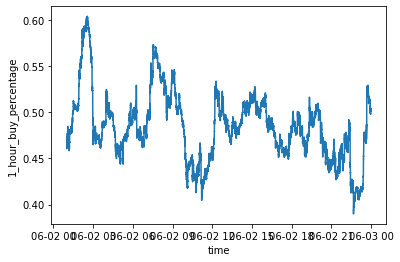

In [15]:
sns.lineplot(data = result.set_index("time")["1_hour_buy_percentage"])


<AxesSubplot:xlabel='time', ylabel='vwap'>

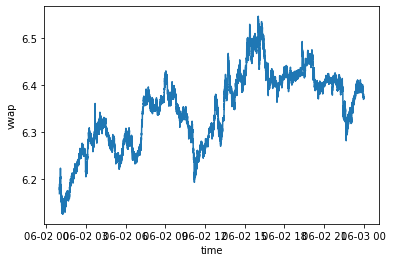

In [18]:
sns.lineplot(data = result.set_index("time")["vwap"])

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [40]:
result_no_time = result.drop(columns = ["time"])
w1 = WindowGenerator(train_df = result_no_time, val_df = None, test_df = None, input_width=60, label_width=1, shift=60,
                     label_columns=["1_min_vwap"])
w1

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [119]
Label column name(s): ['1_min_vwap']

In [41]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [42]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(result_no_time[:w1.total_window_size]),
                           np.array(result_no_time[100:100+w1.total_window_size]),
                           np.array(result_no_time[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 120, 9)
Inputs shape: (3, 60, 9)
labels shape: (3, 1, 1)


In [43]:
w1.example = example_inputs, example_labels

In [47]:
def plot(self, model=None, plot_col='1_min_vwap', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

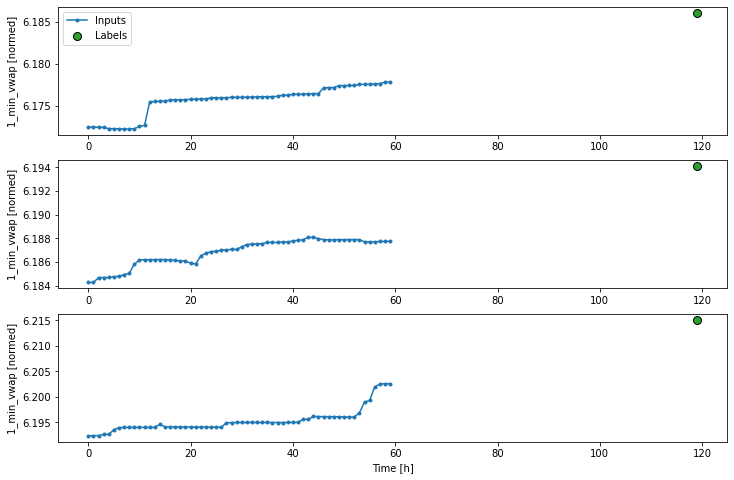

In [48]:
w1.plot()